In [88]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os

In [89]:
"""
Implementation of the VQE algorithm to find the optimum bond-length of dihydride (H₂).
"""

'\nImplementation of the VQE algorithm to find the optimum bond-length of dihydride (H₂).\n'

In [90]:
# Atom symbols for H₂
symbols = ["H", "H"]

# Define coordinates as a function of bond length
def generate_coordinates(bond_length):
    return np.array([
        [0.0, 0.0, 0.0],         # Hydrogen 1
        [0.0, 0.0, bond_length]  # Hydrogen 2
    ])

In [91]:
# Bond scan range
bond_lengths = np.linspace(0.5, 1.8, 25)  # In Ångströms
energies = []

for bond_length in bond_lengths:
    print(f"Running VQE for bond length: {bond_length:.2f} Å")

    # Define the water Hamiltonian and the number of qubits required
    coordinates = generate_coordinates(bond_length)
    coordinates = generate_coordinates(bond_length)

    # Step 1: Define the molecule explicitly
    mol = qchem.Molecule(
        symbols,
        coordinates,
        charge=0,
        mult=1,
        name="h2",
    )

    # Step 2: Generate Hamiltonian with active space restriction
    hamiltonian, qubits = qchem.molecular_hamiltonian(
        mol,
        active_electrons=2,
        active_orbitals=2
    )
    electrons = 2  # 1 from each hydrogen
    print(qubits)

    hf = qchem.hf_state(electrons=electrons, orbitals=qubits)
    singles, doubles = excitations(electrons, qubits)
    num_wires = qubits

    dev = qml.device("default.qubit", wires=num_wires)


    def ansatz(params_singles, params_doubles):
        qml.BasisState(hf, wires=range(num_wires))

        for i, excitation in enumerate(singles):
            qml.SingleExcitation(params_singles[i], wires=excitation)

        for i, excitation in enumerate(doubles):
            qml.DoubleExcitation(params_doubles[i], wires=excitation)


    @qml.qnode(dev)
    def cost_function(params_singles, params_doubles):
        ansatz(params_singles, params_doubles)
        return qml.expval(hamiltonian)

    # Adaptive Moment Estimation (Adam) optimizer
    opt = qml.AdamOptimizer(stepsize=0.4)
    theta_s = np.zeros(len(singles), requires_grad=True)
    theta_d = np.zeros(len(doubles), requires_grad=True)

    for _ in range(25):
        (theta_s, theta_d), _ = opt.step_and_cost(cost_function, theta_s, theta_d)


    energy = cost_function(theta_s, theta_d)
    print(f"  → Final Energy: {energy:.6f} Ha\n")
    energies.append(energy)

Running VQE for bond length: 0.50 Å
4
  → Final Energy: -0.409087 Ha

Running VQE for bond length: 0.55 Å
4
  → Final Energy: -0.568662 Ha

Running VQE for bond length: 0.61 Å
4
  → Final Energy: -0.692862 Ha

Running VQE for bond length: 0.66 Å
4
  → Final Energy: -0.790575 Ha

Running VQE for bond length: 0.72 Å
4
  → Final Energy: -0.868028 Ha

Running VQE for bond length: 0.77 Å
4
  → Final Energy: -0.929705 Ha

Running VQE for bond length: 0.82 Å
4
  → Final Energy: -0.978917 Ha

Running VQE for bond length: 0.88 Å
4
  → Final Energy: -1.018160 Ha

Running VQE for bond length: 0.93 Å
4
  → Final Energy: -1.049351 Ha

Running VQE for bond length: 0.99 Å
4
  → Final Energy: -1.073982 Ha

Running VQE for bond length: 1.04 Å
4
  → Final Energy: -1.093232 Ha

Running VQE for bond length: 1.10 Å
4
  → Final Energy: -1.108039 Ha

Running VQE for bond length: 1.15 Å
4
  → Final Energy: -1.119154 Ha

Running VQE for bond length: 1.20 Å
4
  → Final Energy: -1.127179 Ha

Running VQE for bond

In [92]:
min_index = np.argmin(energies)
print(f"Optimal bond length: {bond_lengths[min_index]:.3f} Å")
print(f"Ground state energy: {energies[min_index]:.6f} Ha")

Optimal bond length: 1.367 Å
Ground state energy: -1.136958 Ha


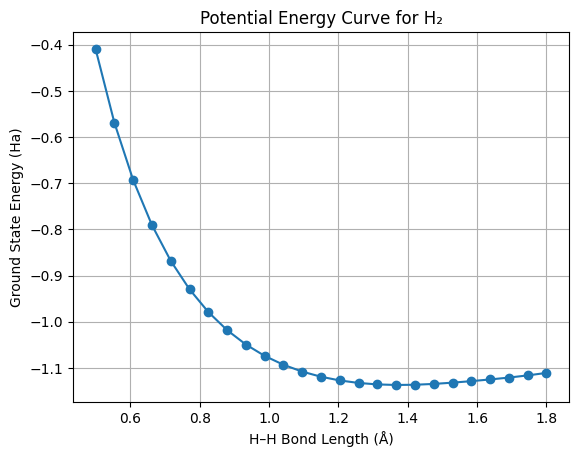

In [93]:
plt.plot(bond_lengths, energies, marker='o')
plt.xlabel("H–H Bond Length (Å)")
plt.ylabel("Ground State Energy (Ha)")
plt.title("Potential Energy Curve for H₂")
plt.grid(True)

# Ensure the "images" directory exists
os.makedirs('images', exist_ok=True)

# Save the figure
plt.savefig("images/H2_Optimal_Bond_Length.png")
plt.show()